In [64]:
%pip install -U imbalanced-learn
%pip install fairlearn
%pip install yellowbrick
%pip install dython

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, multilabel_confusion_matrix, precision_recall_fscore_support, plot_roc_curve, plot_confusion_matrix, plot_precision_recall_curve, plot_det_curve
import matplotlib.pyplot as plt
from yellowbrick.classifier import ROCAUC
from sklego.metrics import p_percent_score
from yellowbrick.classifier import ConfusionMatrix

In [66]:
refugee = pd.read_csv('1milrefugee_range_final_dataset.csv', index_col=0)

In [67]:
df = refugee.copy()

In [68]:
df.tail()

,language,education_level,last_occupation,predicted_employment_nation,mandatory_contribution_range
999995,Native + English,Undergrad,Junior DevOps Professional,UK,£1488 to £6448
999996,Native,Primary,Not employed,UK,£1250 and lower
999997,Native + English,No Education,Construction Worker,UK,£1250 and lower
999998,Native + English,Masters,Senior Administrative Assistant,UK,£1250 and lower
999999,Native + French,High School,Baker,France,£1250 and lower


In [69]:
df['mandatory_contribution_range'].value_counts()

£1250 and lower       731932
£8432 to £16864        91535
£1488 to £6448         69310
£16864 to £33728       53942
£6488 to £8432         31616
£33728 to £58776       13851
£1488                   2771
£58776 to £75640        2095
£92504 and greater      1807
£75640 to £92504        1141
Name: mandatory_contribution_range, dtype: int64

In [70]:
#Measure of association
from dython.nominal import associations
from dython.nominal import identify_nominal_columns
categorical_features=identify_nominal_columns(df)
categorical_features

['language',
 'education_level',
 'last_occupation',
 'predicted_employment_nation',
 'mandatory_contribution_range']

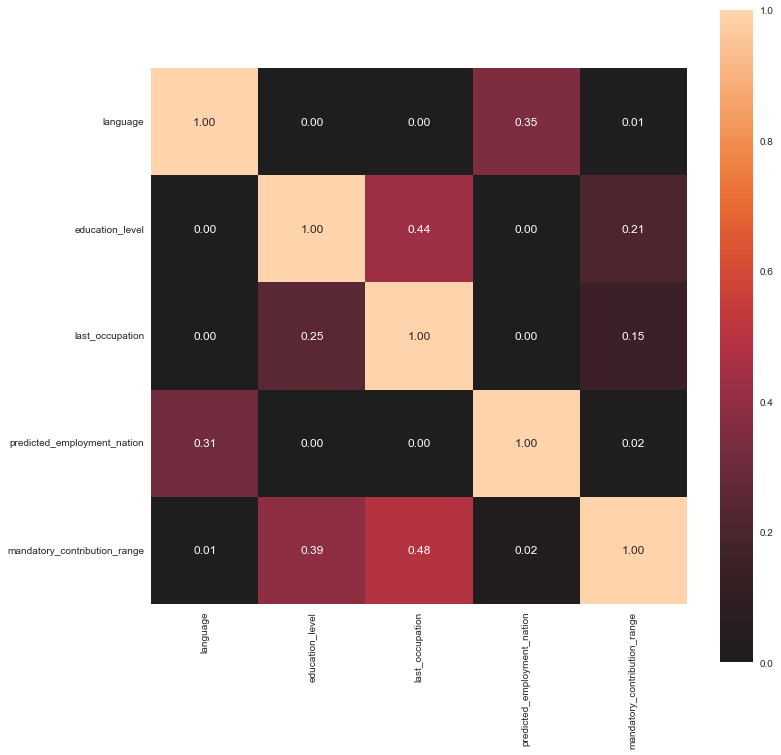

{'corr':                               language  education_level  last_occupation  \
 language                      1.000000         0.000006         0.000084   
 education_level               0.000004         1.000000         0.436449   
 last_occupation               0.000031         0.248150         1.000000   
 predicted_employment_nation   0.306445         0.000008         0.000078   
 mandatory_contribution_range  0.009853         0.390484         0.484534   
 
                               predicted_employment_nation  \
 language                                         0.346061   
 education_level                                  0.000006   
 last_occupation                                  0.000032   
 predicted_employment_nation                      1.000000   
 mandatory_contribution_range                     0.024464   
 
                               mandatory_contribution_range  
 language                                          0.008181  
 education_level              

In [72]:
associations(df, nom_nom_assoc='theil', figsize=(12, 12))

In [20]:
#Divide the data based on their catageory
target_variable = 'mandatory_contribution_range'
encode_variable = ['language', 'education_level', 'last_occupation', 'predicted_employment_nation']

In [21]:
#OneHotEncoding for the features
for col in encode_variable:
    dummy_data = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, dummy_data], axis=1)
    del df[col]

In [22]:
#Label encoding for the feature to maintain the importance of the label values
mapping_target = {'£1250 and lower':0, '£1488':1, '£1488 to £6448':2, '£6488 to £8432':3, '£8432 to £16864':4, '£16864 to £33728':5, '£33728 to £58776':6, '£58776 to £75640':7, '£75640 to £92504':8, '£92504 and greater':9}
def encoded_target(val):
    return mapping_target[val]

In [23]:
#Joining the two encoded datasets into one
df['mandatory_contribution_range'] = df['mandatory_contribution_range'].apply(encoded_target)

In [24]:
#Dividing the new datset into X(features) and y(target-label) 
X = df.drop('mandatory_contribution_range', axis=1)
y = df['mandatory_contribution_range']

In [25]:
y.value_counts()

0    731932
4     91535
2     69310
5     53942
3     31616
6     13851
1      2771
7      2095
9      1807
8      1141
Name: mandatory_contribution_range, dtype: int64

In [46]:
#Splitting the data before rescaling to reduce the chances of data leakage and overfitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

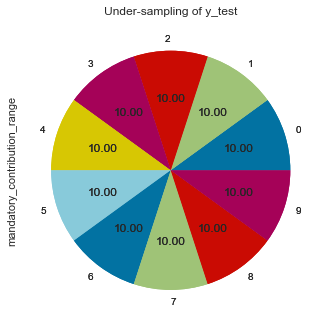

In [47]:
#Using random sampling instead of oversampling to reduce dataleakage, overfitting and duplicate data creation
from imblearn.under_sampling import RandomUnderSampler

#rus = RandomUnderSampler(sampling_strategy=1) # Numerical value
rus = RandomUnderSampler(sampling_strategy="not minority") # String
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)
X_test_us, y_test_us = rus.fit_resample(X_test, y_test)

ax1 = y_train_us.value_counts().plot.pie(autopct='%.2f')
_1 = ax1.set_title("Under-sampling of y_train")
ax2 = y_test_us.value_counts().plot.pie(autopct='%.2f')
_2 = ax2.set_title("Under-sampling of y_test")

In [48]:
from sklearn.preprocessing import MinMaxScaler
min_max=MinMaxScaler()
min_max.fit(X_train_us)
X_train_m = min_max.fit_transform(X_train_us)
X_test_m = min_max.transform(X_test_us)

In [49]:
#Using robustscaler for outliers and also do the scaling after the split to prevent data lickage
#The output is labeled as _p from previous syntex
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train_m)
X_train_p = scaler.transform(X_train_m)
X_test_p = scaler.transform(X_test_m)

Training Score
- accuracy: 0.5229597388465723
- matthews cofficient: 0.47266320473061046
Testing Score
- accuracy: 0.5157657657657657
- matthews cofficient: 0.4640469036135865


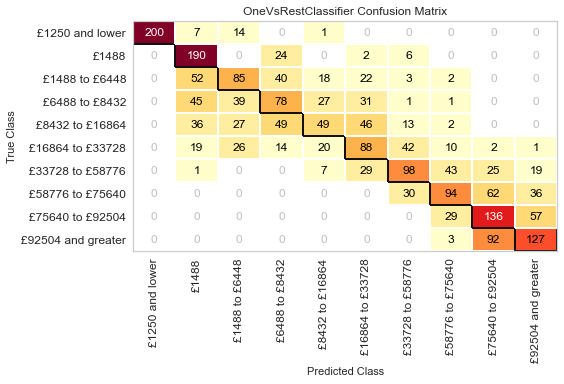

              precision    recall  f1-score   support

           0       1.00      0.87      0.93       919
           1       0.52      0.86      0.65       919
           2       0.45      0.37      0.41       919
           3       0.42      0.37      0.39       919
           4       0.44      0.23      0.30       919
           5       0.45      0.45      0.45       919
           6       0.55      0.48      0.51       919
           7       0.50      0.40      0.44       919
           8       0.43      0.64      0.51       919
           9       0.52      0.56      0.54       919

    accuracy                           0.52      9190
   macro avg       0.53      0.52      0.51      9190
weighted avg       0.53      0.52      0.51      9190

              precision    recall  f1-score   support

           0       1.00      0.90      0.95       222
           1       0.54      0.86      0.66       222
           2       0.45      0.38      0.41       222
           3       0.38 

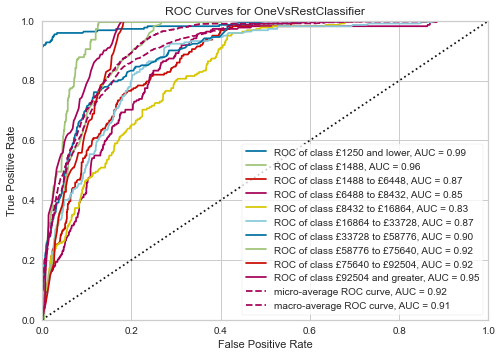

<AxesSubplot:title={'center':'ROC Curves for OneVsRestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [50]:
#Model-One vs Rest Classifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import matthews_corrcoef

#Making the model

#OneVsRestClassifier(LinearSVC(random_state=0)).fit(X, y).predict(X)
omv = OneVsRestClassifier(LinearSVC(max_iter=10000))
omv.fit(X_train_p, y_train_us)


#Predicting
y_train_pred = omv.predict(X_train_p) 
y_test_pred = omv.predict(X_test_p)

#Scoring
omv_train_acu = accuracy_score(y_train_us,y_train_pred)
omv_train_mcc = matthews_corrcoef(y_train_us, y_train_pred)

omv_test_acu = accuracy_score(y_test_us,y_test_pred)
omv_test_mcc = matthews_corrcoef(y_test_us, y_test_pred)


                   

print('Training Score')
print('- accuracy: %s' % omv_train_acu)
print('- matthews cofficient: %s' % omv_train_mcc)
print('Testing Score')
print('- accuracy: %s' % omv_test_acu)
print('- matthews cofficient: %s' % omv_test_mcc)

#Confusion Metrics
omv_cm = ConfusionMatrix(
    omv, classes = ['£1250 and lower', '£1488',
                                    '£1488 to £6448', '£6488 to £8432', 
                                    '£8432 to £16864', '£16864 to £33728', 
                                    '£33728 to £58776', '£58776 to £75640', '£75640 to £92504', '£92504 and greater'])
    


omv_cm.fit(X_train_p, y_train_us)
omv_cm.score(X_test_p, y_test_us)
omv_cm.show()

print(classification_report(y_train_us, y_train_pred))
print(classification_report(y_test_us, y_test_pred))



#Multi-Class ROCAUC Curves
# Creating visualization with the readable labels
visualizer = ROCAUC(omv, classes = ['£1250 and lower', '£1488',
                                    '£1488 to £6448', '£6488 to £8432', 
                                    '£8432 to £16864', '£16864 to £33728', 
                                    '£33728 to £58776', '£58776 to £75640', '£75640 to £92504', '£92504 and greater'])
                    

                                        
# Fitting to the training data first then scoring with the test data                                    
visualizer.fit(X_train_p, y_train_us)
visualizer.score(X_test_p, y_test_us)
visualizer.show()



Training Score
- matthews cofficient: 0.5337202896333041
- accuracy: 0.5337202896333041
Testing Score
- matthews cofficient: 0.457620134472137
- accuracy: 0.457620134472137


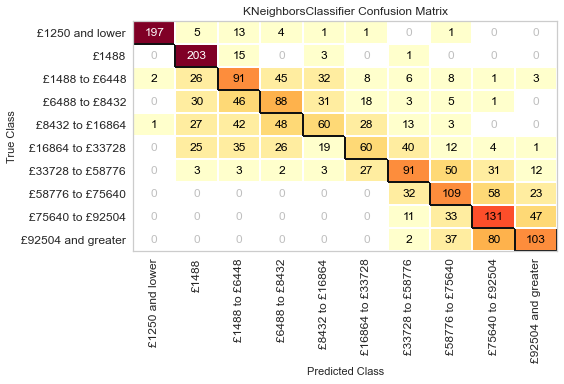

              precision    recall  f1-score   support

           0       0.98      0.87      0.92       919
           1       0.65      0.97      0.78       919
           2       0.50      0.50      0.50       919
           3       0.55      0.54      0.54       919
           4       0.52      0.35      0.42       919
           5       0.55      0.40      0.47       919
           6       0.56      0.52      0.54       919
           7       0.49      0.54      0.51       919
           8       0.48      0.63      0.55       919
           9       0.52      0.47      0.49       919

    accuracy                           0.58      9190
   macro avg       0.58      0.58      0.57      9190
weighted avg       0.58      0.58      0.57      9190

              precision    recall  f1-score   support

           0       0.98      0.89      0.93       222
           1       0.64      0.91      0.75       222
           2       0.37      0.41      0.39       222
           3       0.41 

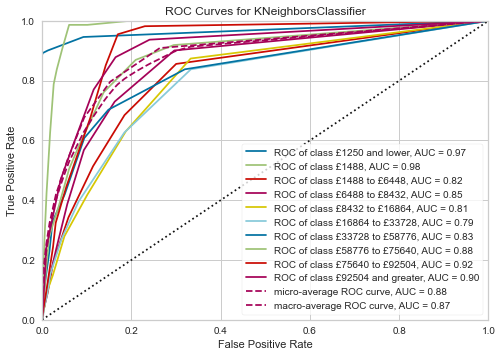

<AxesSubplot:title={'center':'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [51]:
#KNN Model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
#knn = KNeighborsClassifier()
knn.fit(X_train_p, y_train_us)
#Predicting
y_train_pred = knn.predict(X_train_p)
y_test_pred = knn.predict(X_test_p)
#Scoring
knn_mcc_train = matthews_corrcoef(y_train_us, y_train_pred)
knn_acc_train = accuracy_score(y_train_us,y_train_pred)

knn_mcc_test = matthews_corrcoef(y_test_us, y_test_pred)
knn_acc_test = accuracy_score(y_test_us,y_test_pred)

print('Training Score')
print('- matthews cofficient: %s' % knn_mcc_train)
print('- accuracy: %s' % knn_mcc_train)
print('Testing Score')
print('- matthews cofficient: %s' % knn_mcc_test)
print('- accuracy: %s' % knn_mcc_test)

#Confusion Metrics
knn_cm = ConfusionMatrix(
    knn, classes = ['£1250 and lower', '£1488',
                                    '£1488 to £6448', '£6488 to £8432', 
                                    '£8432 to £16864', '£16864 to £33728', 
                                    '£33728 to £58776', '£58776 to £75640', '£75640 to £92504', '£92504 and greater'])
    


knn_cm.fit(X_train_p, y_train_us)
knn_cm.score(X_test_p, y_test_us)
knn_cm.show()

print(classification_report(y_train_us, y_train_pred))
print(classification_report(y_test_us, y_test_pred))

# Creating binary ROAUC visualization with the readable labels
visualizer = ROCAUC(knn, classes = ['£1250 and lower', '£1488',
                                    '£1488 to £6448', '£6488 to £8432', 
                                    '£8432 to £16864', '£16864 to £33728', 
                                    '£33728 to £58776', '£58776 to £75640', '£75640 to £92504', '£92504 and greater'])
                    

                                        
# Fitting to the training data first then scoring with the test data                                    
visualizer.fit(X_train_p, y_train_us)
visualizer.score(X_test_p, y_test_us)
visualizer.show()


Training Score
- accuracy: 0.4155603917301415
- matthews cofficient: 0.3720119292360923
Testing Score
- accuracy: 0.42162162162162165
- matthews cofficient: 0.37727081320145567


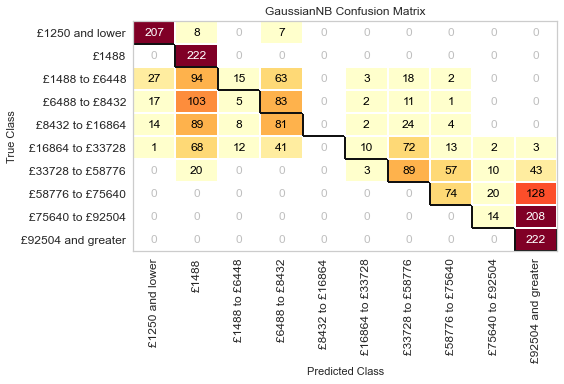

C:\Users\abirm\Envs\acceptance_venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abirm\Envs\acceptance_venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abirm\Envs\acceptance_venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abirm\Envs\ac

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       919
           1       0.34      1.00      0.51       919
           2       0.47      0.08      0.14       919
           3       0.31      0.34      0.32       919
           4       0.00      0.00      0.00       919
           5       0.61      0.05      0.09       919
           6       0.40      0.36      0.38       919
           7       0.47      0.34      0.40       919
           8       0.41      0.08      0.13       919
           9       0.37      1.00      0.54       919

    accuracy                           0.42      9190
   macro avg       0.42      0.42      0.33      9190
weighted avg       0.42      0.42      0.33      9190

              precision    recall  f1-score   support

           0       0.78      0.93      0.85       222
           1       0.37      1.00      0.54       222
           2       0.38      0.07      0.11       222
           3       0.30 

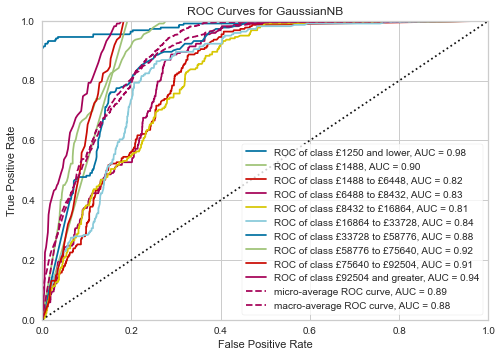

<AxesSubplot:title={'center':'ROC Curves for GaussianNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [52]:
#Niave Bayes model
from sklearn.naive_bayes import GaussianNB

#Making the model
gnb = GaussianNB()
gnb.fit(X_train_p, y_train_us)

#Predicting
y_train_pred = gnb.predict(X_train_p) 
y_test_pred = gnb.predict(X_test_p)

#Scoring
gnb_train_acu = accuracy_score(y_train_us,y_train_pred)
gnb_train_mcc = matthews_corrcoef(y_train_us, y_train_pred)

gnb_test_acu = accuracy_score(y_test_us,y_test_pred)
gnb_test_mcc = matthews_corrcoef(y_test_us, y_test_pred)

print('Training Score')
print('- accuracy: %s' % gnb_train_acu)
print('- matthews cofficient: %s' % gnb_train_mcc)
print('Testing Score')
print('- accuracy: %s' % gnb_test_acu)
print('- matthews cofficient: %s' % gnb_test_mcc)

#Confusion Metrics
gnb_cm = ConfusionMatrix(
    gnb, classes = ['£1250 and lower', '£1488',
                                    '£1488 to £6448', '£6488 to £8432', 
                                    '£8432 to £16864', '£16864 to £33728', 
                                    '£33728 to £58776', '£58776 to £75640', '£75640 to £92504', '£92504 and greater'])
    


gnb_cm.fit(X_train_p, y_train_us)
gnb_cm.score(X_test_p, y_test_us)
gnb_cm.show()

print(classification_report(y_train_us, y_train_pred))
print(classification_report(y_test_us, y_test_pred))

# Creating binary ROAUC visualization with the readable labels
visualizer = ROCAUC(gnb, classes = ['£1250 and lower', '£1488',
                                    '£1488 to £6448', '£6488 to £8432', 
                                    '£8432 to £16864', '£16864 to £33728', 
                                    '£33728 to £58776', '£58776 to £75640', '£75640 to £92504', '£92504 and greater'])
                    

                                        
# Fitting to the training data first then scoring with the test data                                    
visualizer.fit(X_train_p, y_train_us)
visualizer.score(X_test_p, y_test_us)
visualizer.show()

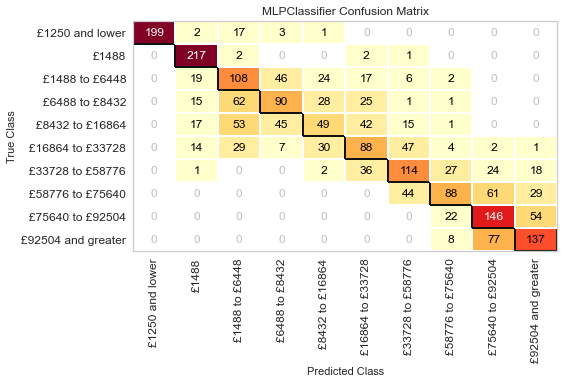

              precision    recall  f1-score   support

           0       1.00      0.86      0.93       919
           1       0.71      0.96      0.82       919
           2       0.43      0.50      0.46       919
           3       0.46      0.41      0.43       919
           4       0.41      0.22      0.29       919
           5       0.46      0.43      0.44       919
           6       0.53      0.56      0.54       919
           7       0.52      0.37      0.43       919
           8       0.47      0.69      0.56       919
           9       0.56      0.55      0.56       919

    accuracy                           0.56      9190
   macro avg       0.55      0.56      0.55      9190
weighted avg       0.55      0.56      0.55      9190

              precision    recall  f1-score   support

           0       1.00      0.90      0.95       222
           1       0.76      0.98      0.86       222
           2       0.40      0.49      0.44       222
           3       0.47 

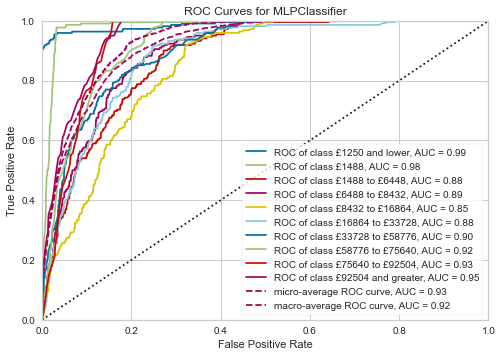

<AxesSubplot:title={'center':'ROC Curves for MLPClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [53]:
#MLP model
from sklearn.neural_network import MLPClassifier

#Making the model
mlp = MLPClassifier(alpha=1, max_iter=1000)
#mlp = MLPClassifier()
mlp.fit(X_train_p, y_train_us)

#Predicting
y_train_pred = mlp.predict(X_train_p) 
y_test_pred = mlp.predict(X_test_p)

#Scoring
mlp_train_acu = accuracy_score(y_train_us,y_train_pred)
mlp_train_mcc = matthews_corrcoef(y_train_us, y_train_pred)

mlp_test_acu = accuracy_score(y_test_us,y_test_pred)
mlp_test_mcc = matthews_corrcoef(y_test_us, y_test_pred)

#Confusion Metrics
mlp_cm = ConfusionMatrix(
    mlp, classes = ['£1250 and lower', '£1488',
                                    '£1488 to £6448', '£6488 to £8432', 
                                    '£8432 to £16864', '£16864 to £33728', 
                                    '£33728 to £58776', '£58776 to £75640', '£75640 to £92504', '£92504 and greater'])
    


mlp_cm.fit(X_train_p, y_train_us)
mlp_cm.score(X_test_p, y_test_us)
mlp_cm.show()

print(classification_report(y_train_us, y_train_pred))
print(classification_report(y_test_us, y_test_pred))

# Creating binary ROAUC visualization with the readable labels
visualizer = ROCAUC(mlp, classes = ['£1250 and lower', '£1488',
                                    '£1488 to £6448', '£6488 to £8432', 
                                    '£8432 to £16864', '£16864 to £33728', 
                                    '£33728 to £58776', '£58776 to £75640', '£75640 to £92504', '£92504 and greater'])
                    

                                        
# Fitting to the training data first then scoring with the test data                                    
visualizer.fit(X_train_p, y_train_us)
visualizer.score(X_test_p, y_test_us)
visualizer.show()

Training Score
- accuracy: 0.6405875952121871
- matthews cofficient: 0.6016331482263451
Testing Score
- accuracy: 0.5666666666666667
- matthews cofficient: 0.5192354327574344


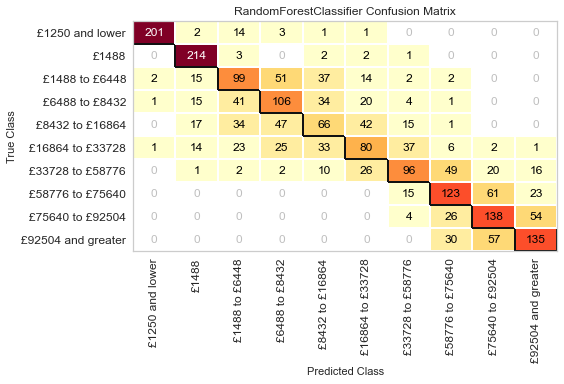

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       919
           1       0.74      0.98      0.84       919
           2       0.63      0.57      0.60       919
           3       0.61      0.61      0.61       919
           4       0.60      0.47      0.53       919
           5       0.60      0.53      0.56       919
           6       0.63      0.55      0.59       919
           7       0.56      0.57      0.57       919
           8       0.51      0.66      0.57       919
           9       0.56      0.57      0.57       919

    accuracy                           0.64      9190
   macro avg       0.64      0.64      0.64      9190
weighted avg       0.64      0.64      0.64      9190

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       222
           1       0.77      0.96      0.86       222
           2       0.46      0.45      0.45       222
           3       0.45 

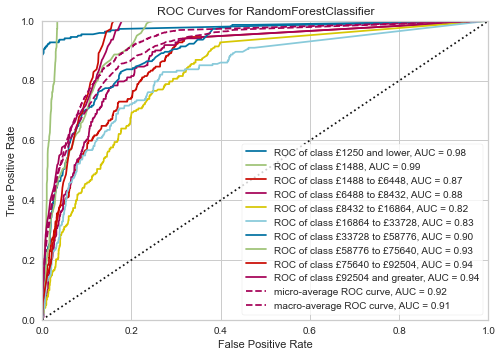

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [54]:
#Model1-RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef
#Making the model
rf_c = RandomForestClassifier(n_estimators=200)
#rf_c = RandomForestClassifier()
rf_c.fit(X_train_p, y_train_us)

#Predicting
y_train_pred = rf_c.predict(X_train_p) 
y_test_pred = rf_c.predict(X_test_p)

#Scoring
rf_c_train_acu = accuracy_score(y_train_us,y_train_pred)
rf_c_train_mcc = matthews_corrcoef(y_train_us, y_train_pred)

rf_c_test_acu = accuracy_score(y_test_us,y_test_pred)
rf_c_test_mcc = matthews_corrcoef(y_test_us, y_test_pred)

print('Training Score')
print('- accuracy: %s' % rf_c_train_acu)
print('- matthews cofficient: %s' % rf_c_train_mcc)
print('Testing Score')
print('- accuracy: %s' % rf_c_test_acu)
print('- matthews cofficient: %s' % rf_c_test_mcc)

#Confusion Metrics
rf_c_cm = ConfusionMatrix(
    rf_c, classes = ['£1250 and lower', '£1488',
                                    '£1488 to £6448', '£6488 to £8432', 
                                    '£8432 to £16864', '£16864 to £33728', 
                                    '£33728 to £58776', '£58776 to £75640', '£75640 to £92504', '£92504 and greater'])
    


rf_c_cm.fit(X_train_p, y_train_us)
rf_c_cm.score(X_test_p, y_test_us)
rf_c_cm.show()

print(classification_report(y_train_us, y_train_pred))
print(classification_report(y_test_us, y_test_pred))

#Multi-Class ROCAUC Curves
# Creating visualization with the readable labels
visualizer = ROCAUC(rf_c, classes = ['£1250 and lower', '£1488',
                                    '£1488 to £6448', '£6488 to £8432', 
                                    '£8432 to £16864', '£16864 to £33728', 
                                    '£33728 to £58776', '£58776 to £75640', '£75640 to £92504', '£92504 and greater'])
                    

                                        
# Fitting to the training data first then scoring with the test data                                    
visualizer.fit(X_train_p, y_train_us)
visualizer.score(X_test_p, y_test_us)
visualizer.show()



Training Score
- accuracy: 0.6405875952121871
- matthews cofficient: 0.6022571279271196
Testing Score
- accuracy: 0.559009009009009
- matthews cofficient: 0.5113227525204306


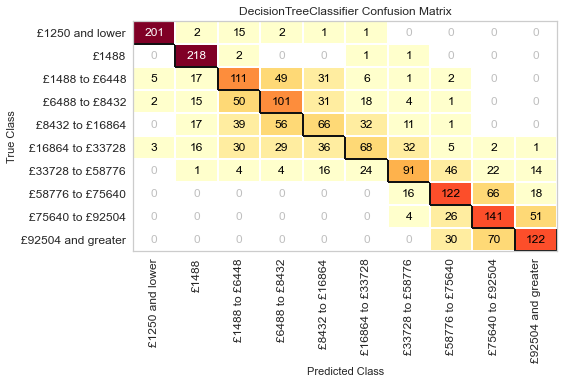

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       919
           1       0.73      0.99      0.84       919
           2       0.60      0.62      0.61       919
           3       0.61      0.63      0.62       919
           4       0.61      0.46      0.52       919
           5       0.64      0.47      0.54       919
           6       0.64      0.53      0.58       919
           7       0.56      0.56      0.56       919
           8       0.49      0.70      0.58       919
           9       0.59      0.53      0.56       919

    accuracy                           0.64      9190
   macro avg       0.64      0.64      0.64      9190
weighted avg       0.64      0.64      0.64      9190

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       222
           1       0.76      0.98      0.86       222
           2       0.44      0.50      0.47       222
           3       0.42 

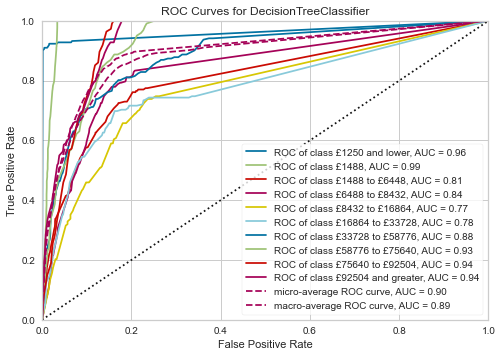

<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [55]:
#Model2- DecissionTree Classifier 

from sklearn.tree import DecisionTreeClassifier
#Making the model
#dt = DecisionTreeClassifier(max_depth=5)
dt = DecisionTreeClassifier()
dt.fit(X_train_p, y_train_us)

#Predicting
y_train_pred = dt.predict(X_train_p) 
y_test_pred = dt.predict(X_test_p)

#Scoring
dt_train_acu = accuracy_score(y_train_us,y_train_pred)
dt_train_mcc = matthews_corrcoef(y_train_us, y_train_pred)

dt_test_acu = accuracy_score(y_test_us,y_test_pred)
dt_test_mcc = matthews_corrcoef(y_test_us, y_test_pred)

print('Training Score')
print('- accuracy: %s' % dt_train_acu)
print('- matthews cofficient: %s' % dt_train_mcc)
print('Testing Score')
print('- accuracy: %s' % dt_test_acu)
print('- matthews cofficient: %s' % dt_test_mcc)

#Confusion Metrics
dt_cm = ConfusionMatrix(
    dt, classes = ['£1250 and lower', '£1488',
                                    '£1488 to £6448', '£6488 to £8432', 
                                    '£8432 to £16864', '£16864 to £33728', 
                                    '£33728 to £58776', '£58776 to £75640', '£75640 to £92504', '£92504 and greater'])
    


dt_cm.fit(X_train_p, y_train_us)
dt_cm.score(X_test_p, y_test_us)
dt_cm.show()

print(classification_report(y_train_us, y_train_pred))
print(classification_report(y_test_us, y_test_pred))

#Multi-Class ROCAUC Curves
# Creating visualization with the readable labels
visualizer = ROCAUC(dt, classes = ['£1250 and lower', '£1488',
                                    '£1488 to £6448', '£6488 to £8432', 
                                    '£8432 to £16864', '£16864 to £33728', 
                                    '£33728 to £58776', '£58776 to £75640', '£75640 to £92504', '£92504 and greater'])
                    

                                        
# Fitting to the training data first then scoring with the test data                                    
visualizer.fit(X_train_p, y_train_us)
visualizer.score(X_test_p, y_test_us)
visualizer.show()

Training Score
- accuracy: 0.6405875952121871
- matthews cofficient: 0.6018451893917478
Testing Score
- accuracy: 0.5527027027027027
- matthews cofficient: 0.503927164742612


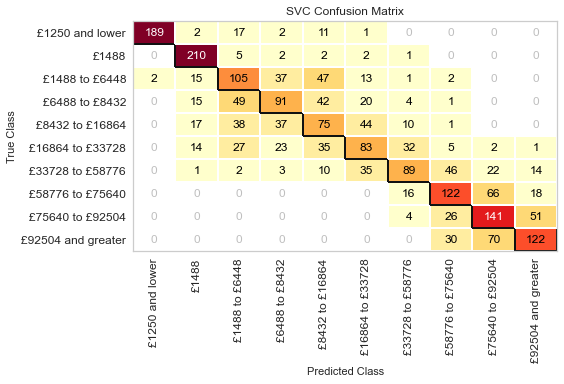

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       919
           1       0.74      0.97      0.84       919
           2       0.62      0.60      0.61       919
           3       0.64      0.56      0.60       919
           4       0.58      0.52      0.55       919
           5       0.60      0.53      0.57       919
           6       0.64      0.53      0.58       919
           7       0.56      0.56      0.56       919
           8       0.49      0.70      0.58       919
           9       0.59      0.53      0.56       919

    accuracy                           0.64      9190
   macro avg       0.65      0.64      0.64      9190
weighted avg       0.65      0.64      0.64      9190

              precision    recall  f1-score   support

           0       0.99      0.85      0.92       222
           1       0.77      0.95      0.85       222
           2       0.43      0.47      0.45       222
           3       0.47 

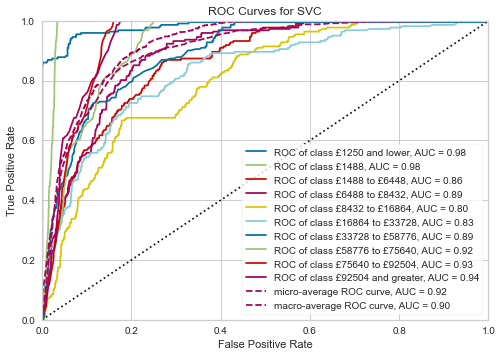

<AxesSubplot:title={'center':'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [56]:
#Model3 - SupportVector Classifier

from sklearn.svm import SVC

#Making the model
svm_rbf = SVC(gamma=2, C=1)
#svm_rbf = SVC()
svm_rbf.fit(X_train_p, y_train_us)

#Predicting
y_train_pred = svm_rbf.predict(X_train_p) 
y_test_pred = svm_rbf.predict(X_test_p)

#Scoring
svm_rbf_train_acu = accuracy_score(y_train_us,y_train_pred)
svm_rbf_train_mcc = matthews_corrcoef(y_train_us, y_train_pred)

svm_rbf_test_acu = accuracy_score(y_test_us,y_test_pred)
svm_rbf_test_mcc = matthews_corrcoef(y_test_us, y_test_pred)

print('Training Score')
print('- accuracy: %s' % svm_rbf_train_acu)
print('- matthews cofficient: %s' % svm_rbf_train_mcc)
print('Testing Score')
print('- accuracy: %s' % svm_rbf_test_acu)
print('- matthews cofficient: %s' % svm_rbf_test_mcc)

#Confusion Metrics
svm_rbf_cm = ConfusionMatrix(
    svm_rbf, classes = ['£1250 and lower', '£1488',
                                    '£1488 to £6448', '£6488 to £8432', 
                                    '£8432 to £16864', '£16864 to £33728', 
                                    '£33728 to £58776', '£58776 to £75640', '£75640 to £92504', '£92504 and greater'])
    


svm_rbf_cm.fit(X_train_p, y_train_us)
svm_rbf_cm.score(X_test_p, y_test_us)
svm_rbf_cm.show()

print(classification_report(y_train_us, y_train_pred))
print(classification_report(y_test_us, y_test_pred))
#Multi-Class ROCAUC Curves
# Creating visualization with the readable labels
visualizer = ROCAUC(svm_rbf, classes = ['£1250 and lower', '£1488',
                                    '£1488 to £6448', '£6488 to £8432', 
                                    '£8432 to £16864', '£16864 to £33728', 
                                    '£33728 to £58776', '£58776 to £75640', '£75640 to £92504', '£92504 and greater'])
                    

                                        
# Fitting to the training data first then scoring with the test data                                    
visualizer.fit(X_train_p, y_train_us)
visualizer.score(X_test_p, y_test_us)
visualizer.show()

Training Score
- accuracy: 0.6356909684439608
- matthews cofficient: 0.5967587982065804
Testing Score
- accuracy: 0.5626126126126126
- matthews cofficient: 0.5150809173485927


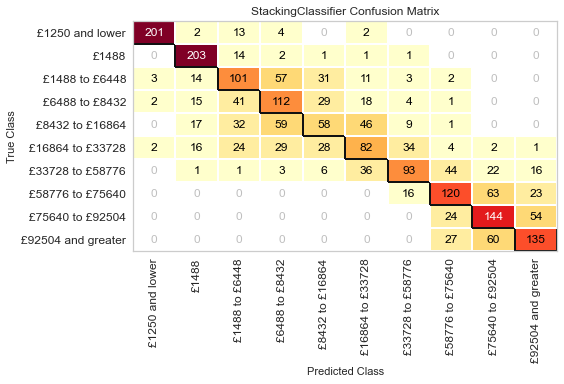

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       919
           1       0.74      0.97      0.84       919
           2       0.62      0.55      0.58       919
           3       0.59      0.69      0.63       919
           4       0.63      0.38      0.48       919
           5       0.57      0.54      0.55       919
           6       0.64      0.54      0.58       919
           7       0.56      0.53      0.54       919
           8       0.50      0.68      0.58       919
           9       0.56      0.57      0.57       919

    accuracy                           0.64      9190
   macro avg       0.64      0.64      0.63      9190
weighted avg       0.64      0.64      0.63      9190

              precision    recall  f1-score   support

           0       0.97      0.91      0.93       222
           1       0.76      0.91      0.83       222
           2       0.45      0.45      0.45       222
           3       0.42 

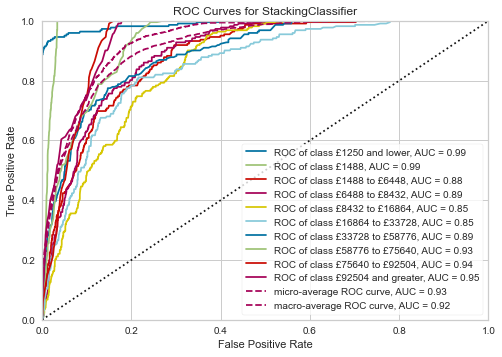

<AxesSubplot:title={'center':'ROC Curves for StackingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [57]:
#The final(1) stacked model

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [
              
              ('dt',dt),
              ('rf_c',rf_c)
]

#Making the model
stack_m1 = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(class_weight='balanced', penalty='elasticnet', solver='saga', max_iter=100000, multi_class='multinomial', l1_ratio=0.8)
)
stack_m1.fit(X_train_p, y_train_us)

#Predicting
y_train_pred = stack_m1.predict(X_train_p) 
y_test_pred = stack_m1.predict(X_test_p)

#Scoring
stack_m1_train_acu = accuracy_score(y_train_us,y_train_pred)
stack_m1_train_mcc = matthews_corrcoef(y_train_us, y_train_pred)

stack_m1_test_acu = accuracy_score(y_test_us,y_test_pred)
stack_m1_test_mcc = matthews_corrcoef(y_test_us, y_test_pred)

print('Training Score')
print('- accuracy: %s' % stack_m1_train_acu)
print('- matthews cofficient: %s' % stack_m1_train_mcc)
print('Testing Score')
print('- accuracy: %s' % stack_m1_test_acu)
print('- matthews cofficient: %s' % stack_m1_test_mcc)

#Confusion Metrics
stack_m1_cm = ConfusionMatrix(
    stack_m1, classes = ['£1250 and lower', '£1488',
                                    '£1488 to £6448', '£6488 to £8432', 
                                    '£8432 to £16864', '£16864 to £33728', 
                                    '£33728 to £58776', '£58776 to £75640', '£75640 to £92504', '£92504 and greater'])
    


stack_m1_cm.fit(X_train_p, y_train_us)
stack_m1_cm.score(X_test_p, y_test_us)
stack_m1_cm.show()


print(classification_report(y_train_us, y_train_pred))
print(classification_report(y_test_us, y_test_pred))
#Multi-Class ROCAUC Curves
# Creating visualization with the readable labels
visualizer = ROCAUC(stack_m1, classes = ['£1250 and lower', '£1488',
                                    '£1488 to £6448', '£6488 to £8432', 
                                    '£8432 to £16864', '£16864 to £33728', 
                                    '£33728 to £58776', '£58776 to £75640', '£75640 to £92504', '£92504 and greater'])
                    

                                        
# Fitting to the training data first then scoring with the test data                                    
visualizer.fit(X_train_p, y_train_us)
visualizer.score(X_test_p, y_test_us)
visualizer.show()

Training Score
- accuracy: 0.6365614798694232
- matthews cofficient: 0.5980170626951675
Testing Score
- accuracy: 0.5621621621621622
- matthews cofficient: 0.514792928533474


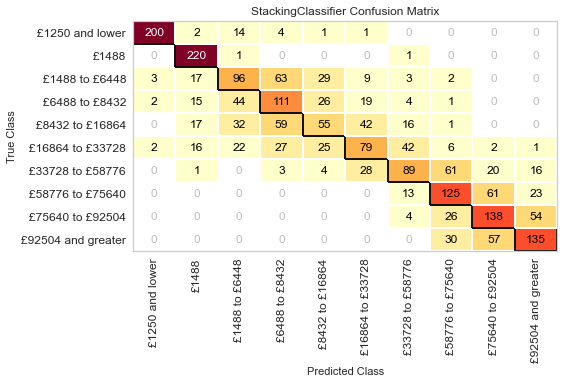

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       919
           1       0.72      0.99      0.84       919
           2       0.64      0.52      0.57       919
           3       0.58      0.69      0.63       919
           4       0.65      0.35      0.46       919
           5       0.59      0.52      0.56       919
           6       0.62      0.55      0.58       919
           7       0.55      0.60      0.58       919
           8       0.51      0.66      0.57       919
           9       0.56      0.57      0.57       919

    accuracy                           0.64      9190
   macro avg       0.64      0.64      0.63      9190
weighted avg       0.64      0.64      0.63      9190

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       222
           1       0.76      0.99      0.86       222
           2       0.46      0.43      0.45       222
           3       0.42 

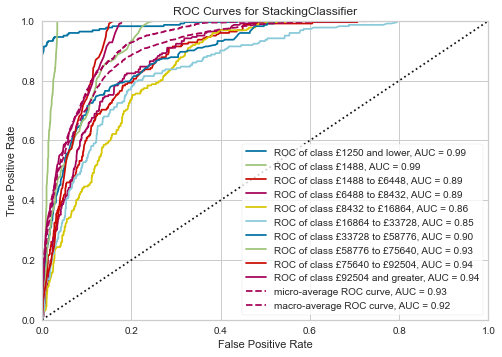

<AxesSubplot:title={'center':'ROC Curves for StackingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [58]:
#The final stacked model

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [
              ('stack_m1',stack_m1),
              ('dt',dt),
              ('rf_c',rf_c),
]

#Making the model
stack_m = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(max_iter=100000)
)
stack_m.fit(X_train_p, y_train_us)

#Predicting
y_train_pred = stack_m.predict(X_train_p) 
y_test_pred = stack_m.predict(X_test_p)

#Scoring
stack_m_train_acu = accuracy_score(y_train_us,y_train_pred)
stack_m_train_mcc = matthews_corrcoef(y_train_us, y_train_pred)

stack_m_test_acu = accuracy_score(y_test_us,y_test_pred)
stack_m_test_mcc = matthews_corrcoef(y_test_us, y_test_pred)

print('Training Score')
print('- accuracy: %s' % stack_m_train_acu)
print('- matthews cofficient: %s' % stack_m_train_mcc)
print('Testing Score')
print('- accuracy: %s' % stack_m_test_acu)
print('- matthews cofficient: %s' % stack_m_test_mcc)

#Confusion Metrics
stack_m_cm = ConfusionMatrix(
    stack_m, classes = ['£1250 and lower', '£1488',
                                    '£1488 to £6448', '£6488 to £8432', 
                                    '£8432 to £16864', '£16864 to £33728', 
                                    '£33728 to £58776', '£58776 to £75640', '£75640 to £92504', '£92504 and greater'])
    


stack_m_cm.fit(X_train_p, y_train_us)
stack_m_cm.score(X_test_p, y_test_us)
stack_m_cm.show()


print(classification_report(y_train_us, y_train_pred))
print(classification_report(y_test_us, y_test_pred))
#Multi-Class ROCAUC Curves
# Creating visualization with the readable labels
visualizer = ROCAUC(stack_m, classes = ['£1250 and lower', '£1488',
                                    '£1488 to £6448', '£6488 to £8432', 
                                    '£8432 to £16864', '£16864 to £33728', 
                                    '£33728 to £58776', '£58776 to £75640', '£75640 to £92504', '£92504 and greater'])
                    

                                        
# Fitting to the training data first then scoring with the test data                                    
visualizer.fit(X_train_p, y_train_us)
visualizer.score(X_test_p, y_test_us)
visualizer.show()

Training Score
- accuracy: 0.6326441784548422
- matthews cofficient: 0.5980170626951675
Testing Score
- accuracy: 0.563963963963964
- matthews cofficient: 0.514792928533474


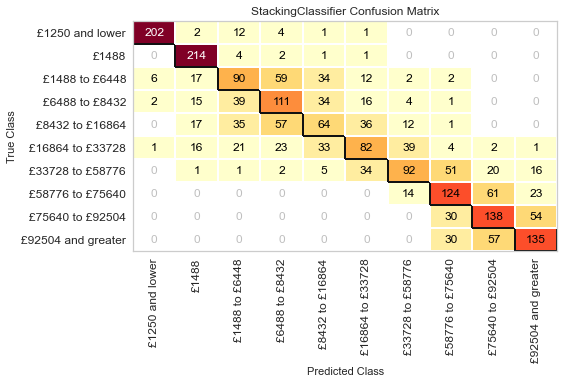

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       919
           1       0.73      0.99      0.84       919
           2       0.63      0.52      0.57       919
           3       0.59      0.68      0.63       919
           4       0.57      0.40      0.47       919
           5       0.58      0.51      0.54       919
           6       0.64      0.52      0.58       919
           7       0.55      0.57      0.56       919
           8       0.51      0.66      0.57       919
           9       0.56      0.57      0.57       919

    accuracy                           0.63      9190
   macro avg       0.63      0.63      0.63      9190
weighted avg       0.63      0.63      0.63      9190

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       222
           1       0.76      0.96      0.85       222
           2       0.45      0.41      0.42       222
           3       0.43 

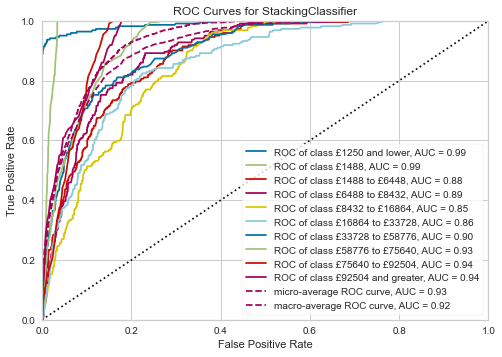

<AxesSubplot:title={'center':'ROC Curves for StackingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [61]:
#The final stacked model

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [
              ('gnb',gnb),
              ('dt',dt),
              ('rf_c',rf_c),
]

#Making the model
stack_m2 = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(max_iter=100000)
)
stack_m2.fit(X_train_p, y_train_us)

#Predicting
y_train_pred = stack_m2.predict(X_train_p) 
y_test_pred = stack_m2.predict(X_test_p)

#Scoring
stack_m2_train_acu = accuracy_score(y_train_us,y_train_pred)
stack_m2_train_mcc = matthews_corrcoef(y_train_us, y_train_pred)

stack_m2_test_acu = accuracy_score(y_test_us,y_test_pred)
stack_m2_test_mcc = matthews_corrcoef(y_test_us, y_test_pred)

print('Training Score')
print('- accuracy: %s' % stack_m2_train_acu)
print('- matthews cofficient: %s' % stack_m_train_mcc)
print('Testing Score')
print('- accuracy: %s' % stack_m2_test_acu)
print('- matthews cofficient: %s' % stack_m_test_mcc)

#Confusion Metrics
stack_m2_cm = ConfusionMatrix(
    stack_m2, classes = ['£1250 and lower', '£1488',
                                    '£1488 to £6448', '£6488 to £8432', 
                                    '£8432 to £16864', '£16864 to £33728', 
                                    '£33728 to £58776', '£58776 to £75640', '£75640 to £92504', '£92504 and greater'])
    


stack_m2_cm.fit(X_train_p, y_train_us)
stack_m2_cm.score(X_test_p, y_test_us)
stack_m2_cm.show()


print(classification_report(y_train_us, y_train_pred))
print(classification_report(y_test_us, y_test_pred))
#Multi-Class ROCAUC Curves
# Creating visualization with the readable labels
visualizer = ROCAUC(stack_m2, classes = ['£1250 and lower', '£1488',
                                    '£1488 to £6448', '£6488 to £8432', 
                                    '£8432 to £16864', '£16864 to £33728', 
                                    '£33728 to £58776', '£58776 to £75640', '£75640 to £92504', '£92504 and greater'])
                    

                                        
# Fitting to the training data first then scoring with the test data                                    
visualizer.fit(X_train_p, y_train_us)
visualizer.score(X_test_p, y_test_us)
visualizer.show()

In [60]:
#import joblib
#range_model = "range_main_model.pkl"
#joblib.dump(stack_m2, range_model)

['range_main_model.pkl']